# Introduction à l'apprentissage automatique - TP6 exercice 2

### Classification d'images au XXIème siècle: _CNN_ et _transfer learning_

<br>

__Remarque préliminaire__: il s'agit plus d'un tutoriel que d'un exercice. Vous n'avez pas de code à écrire, mais passez y suffisamment de temps et assurez-vous de bien comprendre.

<br>

Dans cet exercice, nous mettons en oeuvre des réseaux de neurones convolutifs (_Convolutional neural networks_, CNN). Nous allons utiliser la bibliothèque [Tensorflow](https://www.tensorflow.org/) par l'intermédiaire de l'API Keras qui simplifie la manipulation des réseaux. De nombreuses ressources pédagogiques sont disponibles sur la page web de Tensorflow: elles pourront vous être utiles en stage, pour un projet, etc.

Commencez par prendre connaissance des pages suivantes:
* [Page wikipedia Keras](https://fr.wikipedia.org/wiki/Keras)
* [Page wikipedia Tensorflow](https://fr.wikipedia.org/wiki/TensorFlow)


<br>

Installez Tensorflow et Keras si ce n'est déjà fait: voir les instructions sur la page Arche du cours. 


<br>

La partie "prédiction" de l'exercice est partiellement une adaptation simplifiée de [cette page](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) du blog de François Chollet, papa de Keras. Lisez cette page __à la fin du TP__, notamment ce qui concerne la génération d'images synthétiques pour augmenter la base d'apprentissage, que nous n'abordons pas ici par souci de simplicité. Par ailleurs, le problème __chiens et chats__ du blog ne concerne que deux classes alors que le nôtre est multiclasses (7 classes à identifier).

Nous allons donc adapter les réseaux décrits sur la page du blog de la manière suivante:
- il faut 7 neurones sur la couche de sortie, qui doit être de type `softmax` (dans le cas biclasse, il faut un seul neurone de sortie, de type `sigmoid`, comme expliqué en cours)
- le _loss_ est de type `categorical_crossentropy` et non `binary_crossentropy`, comme dans le cours également.

## 0. Préparatifs

On commence par charger quelques bibliothèques et définir la fonction `display_test` (comme dans l'exercice précédent).

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn import model_selection

%matplotlib inline

def display_test(X_image_test,Y_test,Y_test_pred,dict_classes,txt):
    # affiche les résultats de classification pour 120 images aléatoires
    # paramètres: 
    # X_image_test: tableau des images de test 
    # Y_test: classes d'appartenance réelles
    # Y_test_pred: classes prédites
    # txt: légende de la figure
    alea=np.random.choice(len(X_image_test),size=120,replace=False)
    plt.figure(figsize=[18,12])    
    for n in range(120):
        plt.subplot(12,10,n+1,xticks=[],yticks=[])
        plt.imshow(X_image_test[alea[n]],cmap='gray')
        if Y_test_pred[alea[n]]==Y_test[alea[n]]:
            plt.text(0.1,0.1,str(dict_classes[Y_test_pred[alea[n]]])+' / '+str(dict_classes[Y_test[alea[n]]]),fontsize=8,bbox=dict(facecolor='white', alpha=1))
        else:
            plt.text(0.1,0.1,str(dict_classes[Y_test_pred[alea[n]]])+' / '+str(dict_classes[Y_test[alea[n]]]),fontsize=8,bbox=dict(facecolor='red', alpha=1))
    plt.suptitle('prediction '+txt+'  --  classe prédite / classe réelle')
    plt.show()

On charge à présent les données. Cette fois, nos classifieurs vont admettre directement les images en entrée, et pas des descripteurs comme les histogrammes de l'exercice 1. Comme les réseaux de neurones utilisés exigent des images de taille identique en entrée, il va falloir redimensionner les images de la base de données avant de les stocker dans les tableaux `X_train` et `X_test`. On choisit une taille de redimensionnement de $150\times 100$ pixels (150 colonnes et 100 lignes), ce qui a l'avantage de ne pas trop déformer la majorité des images (l'"aspect ratio", c'est-à-dire le rapport entre hauteur et largeur, est globalement conservé).

Notez le nombre d'images dans les bases d'entraînement et de test.

In [2]:
from PIL import Image  # on utilise la bibliothèque de manipulation d'image PIL pour redimensionner les images

# modifiez ici le chemin d'accès à vos données si besoin:
path="./Caltech256_small/" 

X=[]
Y=[]
X_image=[]
X_train=[]
X_test=[]
dict_class_names={}  # dictionnaire associant labels et noms des classes

y=0  # numéro de classe

for directory in os.listdir(path):
    count = 0 # indice de l'image traitée dans le répertoire courant
    print("%s  - classe: %d" % (directory,y))
    dict_class_names[y]=directory[4:]
    for file in os.listdir(path+directory):
        img = plt.imread(path+directory+"/"+file)
        if (len(img.shape)==2):
            img=np.repeat(img[:,:,np.newaxis],3,axis=2)        
        X_image.append(img)
        Y.append(y)
        count = count+1
    y = y+1
    
X_image_train, X_image_test, Y_train, Y_test = model_selection.train_test_split(X_image, Y, test_size=0.2, random_state=1)

for i in range(len(X_image_train)):
    img=X_image_train[i]
    imgresize=np.array(Image.fromarray(img).resize((150,100)))/256  # images redimensionnées, et canaux normalisés entre 0 et 1
    X_train.append(imgresize)

for i in range(len(X_image_test)):
    img=X_image_test[i]
    imgresize=np.array(Image.fromarray(img).resize((150,100)))/256  # images redimensionnées, et canaux normalisés entre 0 et 1
    X_test.append(imgresize)


# tensorflow demande que les données soient représentées comme un tableau numpy:    
X_train=np.asarray(X_train)
Y_train=np.asarray(Y_train)
X_test=np.asarray(X_test)
Y_test=np.asarray(Y_test)

print("base d'apprentissage: %d images" %X_train.shape[0])
print("base de test: %d images" %X_test.shape[0])
print("\ndimension des tableaux:")
print("X_train")
print(X_train.shape)
print("Y_train")
print(Y_train.shape)
print("X_test")
print(X_test.shape)
print("Y_test")
print(Y_test.shape)


012.binoculars  - classe: 0
090.gorilla  - classe: 1
105.horse  - classe: 2
145.motorbikes-101  - classe: 3
205.superman  - classe: 4
251.airplanes-101  - classe: 5
253.faces-easy-101  - classe: 6
base d'apprentissage: 1052 images
base de test: 263 images

dimension des tableaux:
X_train
(1052, 100, 150, 3)
Y_train
(1052,)
X_test
(263, 100, 150, 3)
Y_test
(263,)


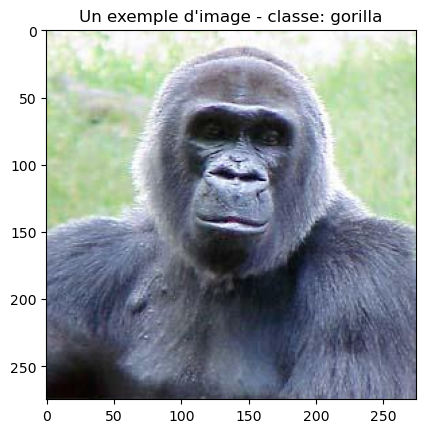

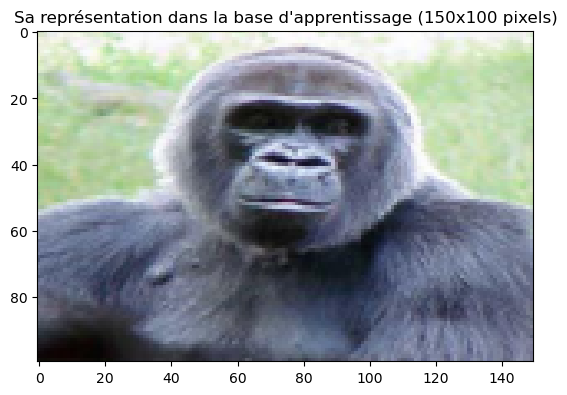

In [3]:
n_image=200  # essayez d'autres valeurs
plt.figure()
plt.imshow(X_image_train[n_image]);
plt.title("Un exemple d'image - classe: "+str(dict_class_names[Y_train[n_image]]));
plt.figure()
plt.imshow(X_train[n_image].reshape(100,150,3))
plt.title("Sa représentation dans la base d'apprentissage (150x100 pixels)")
plt.show()

<br>

## 1. Classification par un réseau convolutif

Nous allons tester le premier réseau étudié dans le blog de F. Chollet, inspiré des réseaux convolutifs comme __[LeNet5](http://yann.lecun.com/exdb/lenet/index.html)__ proposés par __[Yann Le Cun](https://fr.wikipedia.org/wiki/Yann_Le_Cun)__ dans les années 1990.

Le réseau est formé des couches suivantes.

Partie "définition de descripteurs" ( _features_ ):
- entrée: un image couleur (trois canaux: rouge, vert, bleu) de taille $150\times 100$ pixels
- une couche convolutive de 32 filtres de couverture spatiale $3\times3$ pixels (ce sont donc des filtres $3\times 3\times 3$ car ils agissent sur les trois canaux), chaque neurone ayant une activation ReLU.
- une couche `MaxPooling` réduisant d'un facteur 2 la largeur et hauteur des sorties (mais pas la profondeur)
- une couche convolutive de 32 filtres $3\times3$ (ce sont donc des filtres $3\times 3\times 32$ car ils agissent sur toute la profondeur de la couche précédente), activation ReLU
- une couche `MaxPooling` 
- une couche convolutive de 64 filtres $3\times3$, activation ReLU
- une couche `MaxPooling` 

Partie "classification", qui ressemble au perceptron multi-couches de l'exercice précédent:
- pour commencer on "applatit" la couche finale de la partie précédente, qui est alors vue comme une colonne de neurones.
- une couche "fully connected" de 64 neurones, activation ReLU, et dropout de 0.5. Cela signifie que pendant l'apprentissage, pour chaque batch traité on élimine aléatoirement 50% des connexions. Cela a pour effet d'éviter que le réseau s'adapte trop bien aux données d'apprentissage, et donc d'éviter le surapprentissage, comme expliqué dans le polycopié. Naturellement, lorsque le réseau est utilisé après apprentissage pour faire une prédiction (étape dite d'inférence), il n'y a pas de _dropout_. 
- une couche de sortie SoftMax à 7 neurones (car nous devons discriminer 7 classes)

__Remarque:__ si vous utilisez une version de Tensorflow > 2.16, vous aurez un avertissement (`UserWarning: Do not pass an input_shape/input_dim argument to a layer`) dû au passage à Keras 3.0, dont nous ne tiendrons pas compte.

In [4]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils import plot_model

model = Sequential() # le réseau est défini couche après couche dans ce qui suit

# partie "features"

model.add(Conv2D(32, (3, 3), input_shape=(100, 150, 3), padding='same'))   # 100 lignes et 150 colonnes (notation matricielle)
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# à ce stade, ce réseau prend en entrée une image et sort ses caractéristiques sous la forme d'un "tenseur" 3D

ModuleNotFoundError: No module named 'keras'

In [ ]:
# partie "classifier"

model.add(Flatten())  #  Ceci transforme les caractéristique 3D en une "colonne" de neurones d'entrée, comme dans les MLP classiques
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))  # vous commenterez cette ligne pour essayer sans dropout (voir plus loin dans le sujet)
model.add(Dense(7))  
model.add(Activation('softmax'))  

In [ ]:
# on précise à présent le loss à optimiser (ici, "sparse" car les "y" sont codés comme des entiers et pas par "one-hot-encoding")
# ainsi qu'une métrique à afficher (score de classification) et un optimiseur (rmsprop adapte le taux d'apprentissage automatiquement)

model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='rmsprop')

In [ ]:
# résumé du modèle précédemment défini:
model.summary()


On voit que la sortie de la partie "convolutive" est un tenseur de dimension $12\times 18\times 64 = 13 824$, qui est représenté par un vecteur de dimension $13 824$ après "aplattisement" (_flattening_).

Ce modèle nécessite l'apprentissage de 913 895 paramètres, qui sont dans la partie "fully connected" pour la très grande majorité. Par exemple, la seconde couche de convolution nécessite l'estimation de 9248 paramètres. En effet, elle effectue 32 convolutions de taille $3 \times 3 \times \text{(épaisseur de la sortie de la couche précédente)}$, soit: $(9\times 32+1)\times 32 = 9248$ paramètres (la couche précédente effectue 32 convolutions, et +1 car il faut ajouter le terme de biais).

Remarquez l'argument `padding='same'` des couches convolutives: des zéros sont ajoutés à l'extérieur des bords de l'entrée de la convolution  de manière à ce que le résultat de la convolution ait la même taille que l'entrée. 


<br>

L'apprentissage proprement dit se lance dans la cellule suivante. Notez la taille des batches utilisés ainsi que le nombre d'epochs. Les données de validation ne sont pas utilisées pour l'apprentissage (à la fin de chaque epoch), seulement à titre indicatif pour surveiller un surapprentissage potentiel, comme expliqué en cours. Constatez la décroissance du _loss_ au cours de l'apprentissage. L'_accuracy_ est calculée également mais n'intervient pas dans l'apprentissage: il s'agit de la proportion de prédictions correctes dans la base d'apprentissage et dans la base de test/validation.

In [ ]:
model.fit(X_train,Y_train,batch_size=32,epochs=10,validation_data=(X_test,Y_test))

Constatez que ce réseau convolutif présente de meilleures performance que le meilleur modèle de l'exercice 1 (si ce n'est pas le cas, vous n'avez pas eu de chance: relancez la cellule précédente qui continuera l'apprentissage pour 10 nouvelles époques). Le modèle présente sans doute un peu de surapprentissage: `accuracy` sur la base d'apprentissage est assez sensiblement supérieur à `val_accuracy` (sur la base test).

Vérifiez le rôle du _dropout_: commentez la ligne `model.add(Dropout(0.5))` dans ce qui précède, et relancez la construction (à partir de la cellule où figure `model = Sequential()`) puis l'apprentissage du réseau (attention: il ne suffit pas de relancer le `fit` car on continuerait alors l'apprentissage à partir des paramètres déjà estimés). Vous allez voir le réseau apprendre "quasiment par coeur" la base d'apprentissage (_
`accuracy` à 0.98-0.99) mais une accuracy sur la base de test (`val_accuracy`)qui plafonne à 0.80-0.82. N'oubliez pas de revenir au réseau appris avec _dropout_ avant de continuer.

_Remarque_: il ne faut pas perdre de vue que notre base de données est assez petite. On pourrait utiliser un réseau plus simple avec des performances similaires.


<br>

La cellule suivante permet de calculer les prédictions du réseau (`predict`) sur la base test. Il s'agit des probabilités _a posteriori_ de chaque classe, on assigne donc chaque observation à la classe de probabilité maximale, selon le principe MAP. 

In [ ]:
from sklearn import metrics

y_proba = model.predict(X_test)
print(y_proba) # les proba a posteriori de chaque classe

Y_test_pred=y_proba.argmax(axis=1)  # classe prédite: celle de probabilité maximale

print("classes prédites:")
print(Y_test_pred)
print("vraies classes:")
print(Y_test)
print("\nscore de classification: %.3f\n" %metrics.accuracy_score(Y_test,Y_test_pred))

print("matrice de confusion")
print(metrics.confusion_matrix(Y_test,Y_test_pred))

display_test(X_image_test,Y_test,Y_test_pred,dict_class_names,'CNN')

Les classes binoculars (0), gorilla (1), horses (2), ainsi que airplanes (5) restent les plus difficiles à discriminer, comme dans l'exercice 1.

<br>

## 2. Génération aléatoire d'exemples contradictoires (ou antagonistes)

Un "exemple contradictoire" ou "antagoniste" (_adverserial example_) est une entrée de réseau (ici, une image) spécialement modifiée pour que la classe prédite par le réseau ne soit pas la classe qu'un humain attribuerait. On parle d'"attaque par exemple contradictoire" dans un scénario où on cherche une image qui va tromper le réseau sans éveiller l'attention d'un humain.


<br>

La cellule suivante prend une image-test, et change aléatoirement la valeur (R,V,B) de pixels par un triplet dont les composantes varient entre $0$ et $M=10$, jusqu'à ce que l'image ne soit plus classée dans la bonne catégorie...  

In [ ]:
adv_example=np.zeros([1, 100, 150, 3])
adv_example[0,:,:,:]=X_test[100]  # vous pouvez expérimenter avec d'autres images
init_pred=model.predict(adv_example).argmax()  # classe prédite pour l'image initiale

plt.figure(figsize=[12,8])
plt.imshow(adv_example[0])
plt.title("classe prédite pour l'exemple de test considéré: %s" % dict_class_names[init_pred])
plt.show()

M=10
count=0
for c in range(1000):
    count=count+1
    adv_example[0,np.random.randint(low=0,high=100),np.random.randint(low=0,high=150),:] = M*(np.random.random_sample((3,)))
    adv_pred=model.predict(adv_example, verbose=0).argmax()
    if (adv_pred!=init_pred):
        break

plt.figure(figsize=[12,8])
plt.imshow(adv_example[0])
plt.title("classe prédite pour l'exemple de test considéré: %s - %d pixels modifiés" % (dict_class_names[adv_pred], count));
plt.show()           

Quelques remarques...

L'objectif de cette expérience très simple est d'illustrer que la perception humaine n'a rien à voir avec la classification algorithmique.

Relancez plusieurs fois la cellule: vous voyez que la classe affectée à notre exemple contradictoire peut changer, et que quelques pixels suffisent à tromper le modèle. A quelques pixels près, un avion est reconnu comme un cheval...

En fait on triche un peu ici: on autorise des modifications des valeurs des pixels entre 0 et M=10, alors que les composantes RVB des "vraies" images varient entre 0 et 1.

Dans les exemples présentés en cours (issus d'articles de recherche récents), les "perturbations contradictoires" ne sont pas générées aléatoirement, mais en fonction du modèle de classification, et de manière à atteindre une classe prédeterminée. Voir la section 5 à la fin du carnet.


<br>

## 3. Apprentissage par transfert

<br>

L'apprentissage est limité par la taille de la base d'apprentissage: nous avons dans chaque catégorie de l'ordre de 200 images de taille $150\times100\times3$, pour apprendre plus de 900000 paramètres.

Une manière de surmonter cette difficulté est de réutiliser un réseau profond, plus complexe que le précédent, dont les paramètres auront été appris au préalable sur une très grande base de données par des chercheurs ou entreprises disposant de grandes ressources de calcul. On parle d'apprentissage _par transfert_.

Nous allons adapter le réseau VGG16, décrit dans le polycopié. VGG16 a été construit pour un problème de classification à 1000 classes, et ses paramètres ont été appris sur 14 millions d'images.

L'idée est d'utiliser uniquement la partie de VGG16 construisant des descripteurs (on ne modifie pas les paramètres de cette partie), puis d'utiliser ces descripteurs en entrée d'un classifieur permettant de discriminer 7 classes. Seuls les paramètres de la partie "classifieur" seront appris sur nos données. On peut aussi dire qu'on remplace la partie "features" du modèle CNN précédent par la partie "features" de VGG16 dont on ne modifie pas les poids. Remarquons au passage que nous pourrions utiliser un autre classifieur qu'un réseau de neurones (les curieux pourront aller voir la section suivante du carnet).

Bien entendu, tout cela a une chance raisonnable de fonctionner si les descripteurs fournis par VGG16 sont bien adaptés à nos images, donc si les images d'apprentissage de VGG16 ressemblent aux nôtres. C'est globalement le cas ici, même si les classes que nous cherchons à identifier ne sont pas présentes dans VGG16: ce n'est pas un problème puisque nous entraînerons la partie "classifieur" sur nos données.

Voir plus bas en cas de capacités de calcul, de bande passante réseau, ou d'espace disque limitées.

In [ ]:
from tensorflow.keras import applications

# on charge VGG16 dont les paramètres ont été appris sur le dataset Imagenet, 
# sans la couche "top" de classification (on utilise donc uniquement la partie "features")
# (peut prendre plusieurs minutes)
modelVGG = applications.VGG16(include_top=False, weights='imagenet')

modelVGG.summary()


Les 14 millions de paramètres sont (heureusment) déjà entraînés.

On remarque que si on considère uniquement la partie convolutive du réseau (le modèle précédent), la dimension des images en entrée peut être arbitraire (d'où les `None` dans le tableau ci-dessus). En effet, les paramètres sont ici les coefficients des noyaux de convolution, et les convolutions peuvent s'appliquer sur des images de taille arbitraire. La seule contrainte est que les images en entrée doivent avoir trois canaux (les noyaux de convolutions de la première couche sont de taille $3 \times 3 \times 3$). Comme nos images en entrée ont toute la même définition, les _features_ en sortie auront aussi tous la même dimension.

On peut donc calculer les caractéristiques ( _features_ ) de nos images train et test à l'aide de `modelVGG`:

In [ ]:
# peut prendre quelques minutes

features_train = modelVGG.predict(X_train)
np.save('features_train.npy',features_train) 
print(features_train.shape)

features_test = modelVGG.predict(X_test)
np.save('features_test.npy',features_test)
print(features_test.shape)

# vous pouvez aussi continuer en chargeant les variables sans les calculer: 
# il suffit de commenter les lignes précédentes et décommenter les lignes suivantes (voir explications ci-dessous)
#features_train = np.load('features_train.npy')
#features_test = np.load('features_test.npy')

La base d'apprentissage est formée de 1052 observations, celle de test de 263 observations. La sortie de la partie "convolutive" de VGG16 est constituée de blocs de $3\times 4\times 512$ valeurs (512 convolutions dans la dernière couche convolutive, qui sortent chacune $3\times 4$ valeurs pour nos entrées de taille $100\times150$).

Au cas où votre connexion (ou votre espace disque) ne vous permet pas de charger VGG16, ou si votre processeur n'est pas assez rapide, vous pouvez charger les features calculés pour vous, à ces liens ou sur Arche:
- [features pour la base d'apprentissage](https://members.loria.fr/FSur/enseignement/apprauto/features_train.npy)
- [features pour la base de test](https://members.loria.fr/FSur/enseignement/apprauto/features_test.npy)

à stocker dans la variable correspondante par: 

```
features_train = np.load('features_train.npy')

features_test = np.load('features_test.npy')
```

__Attention__: ces features sont calculés sur des images chargées dans l'ordre de numérotation des répertoires correspondant aux classes (classe 0: binoculars; 1: gorilla, 2: horses, etc.), et séparées de la même manière par `train_test_split`. Sur certains OS, les images ne sont pas chargées dans le même ordre, ou la séparation aléatoire entre bases d'apprentissage et de test diffère (même en précisant la _seed_ du générateur aléatoire): il est alors impossible d'utiliser ces fichiers.

Ensuite, on définit le réseau classifieur qui admettra en entrée les caractéristiques précédentes (de dimension  3x4x512=6144 ici) et calculera les probabilités a posteriori. 

Ce réseau est constitué:
* d'une couche d'entrée où on "applatit" les _features_ (ce sont donc des vecteurs de dimension 6144), 
* d'une simple couche cachée de 256 neurones (notez le dropout), 
* et de 7 neurones de sortie (autant que de catégories). 

N'hésitez pas à expérimenter avec d'autre valeurs que 256 neurones dans la couche cachée. 

In [ ]:
model_classif = Sequential()
model_classif.add(Flatten(input_shape=features_train.shape[1:]))
model_classif.add(Dense(256, activation='relu'))
model_classif.add(Dropout(0.5))
model_classif.add(Dense(7, activation='softmax'))  

model_classif.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',  
              metrics=['accuracy'])

model_classif.summary()


On entraîne à présent notre classifieur sur les _features_ de VGG16. Notez que l'apprentissage est très rapide.

In [ ]:
model_classif.fit(features_train, Y_train, epochs=10, batch_size=16, validation_data=(features_test, Y_test))
# model.save_weights('model_classif.h5')  # (pour sauvegarder le réseau entraîné)

On visualise le résultat final:

In [ ]:
y_proba = model_classif.predict(features_test)
#print(y_proba)
Y_test_pred = y_proba.argmax(axis=1)

print("classes prédites:")
print(Y_test_pred)

print("score de classification: %.3f" %metrics.accuracy_score(Y_test,Y_test_pred))

print("matrice de confusion")
print(metrics.confusion_matrix(Y_test,Y_test_pred))

display_test(X_image_test,Y_test,Y_test_pred,dict_class_names,'with pretrained network')

Le taux de classifiations correctes est à présent supérieur à 95%. Certaines classes ne contiennent aucune erreur.

<br>

Au passage, notons que notre génération aléatoire d'exemples contradictoires fonctionne toujours, comme on peut le constater à l'aide de la cellule suivante. Il faut néanmoins modifier un plus grand nombre de pixels.

In [ ]:
adv_example=np.zeros([1, 100, 150, 3])
adv_example[0,:,:,:]=X_test[100]
init_pred=model_classif.predict(modelVGG.predict(adv_example)).argmax()

plt.figure(figsize=[12,8])
plt.imshow(adv_example[0])
plt.title("classe prédite pour l'exemple de test considéré: %s" % dict_class_names[init_pred])

M=10
count=0
for c in range(1000):
    count=count+1
    adv_example[0,np.random.randint(low=0,high=100),np.random.randint(low=0,high=150),:] = M*(np.random.randint((3,)))
    adv_pred=model_classif.predict(modelVGG.predict(adv_example,verbose=0),verbose=0).argmax(axis=1)
    if (adv_pred!=init_pred):
        break

plt.figure(figsize=[12,8])
plt.imshow(adv_example[0])
plt.title("classe prédite pour l'exemple de test considéré: %s - %d pixels modifiés" % (dict_class_names[adv_pred[0]], count))
plt.show()

<br>

## 4. Et si on utilisait un autre classifieur qu'un MLP sur les descripteurs calculés par VGG16? 

<br>

Dans notre expérience d'apprentissage par transfert, on utilise des descripteurs calculés par la partie "convolutive" de VGG16, puis on entraîne un perceptron multicouche (MLP) classifieur de manière à discriminer nos sept classes. Comme nous l'avons suggéré plus haut, on pourrait envisager d'utiliser autre chose qu'un MLP. Nous allons tester ce que donnerait la SVM RBF.

<br>

En sortie de VGG16, les descripteurs sont des tableaux multidimensionnels de taille $3\times 4\times 512$, que l'on commence par transformer en des vecteurs de dimension 6144 dans la cellule suivante:

In [ ]:
X_train_svm=[]
X_test_svm=[]
for i in range(len(features_train)):
    X_train_svm.append(features_train[i].flatten())
for i in range(len(features_test)):
    X_test_svm.append(features_test[i].flatten())
print("\n%d observations dans la base d'apprentissage, chacune est décrite par un vecteur de dimension %d" % (len(X_train_svm), len(X_train_svm[0])) )
print("\n%d observations dans la base de test, chacune est décrite par un vecteur de dimension %d" % (len(X_test_svm), len(X_test_svm[0])) )


Ensuite on cherche la valeur optimale pour l'hyperparamètre $C$ (peut prendre une à deux minutes):

In [ ]:
from sklearn import svm, model_selection, metrics

C_range=10**np.arange(-3,3.5,1)
parameters = {'C':C_range}

SVM = svm.SVC(kernel='rbf')
parameters = { 'C':C_range }
gridsearch=model_selection.GridSearchCV(SVM, parameters, cv=5, n_jobs=-1)
gridsearch.fit(X_train_svm,Y_train)
print("Meilleur paramètre pour SVM_rbf:")
print(gridsearch.best_params_)

scores = gridsearch.cv_results_['mean_test_score']
plt.figure(figsize=[7,7])
plt.semilogx(C_range,scores)
plt.grid()
plt.xlabel('C')
plt.ylabel("score")
plt.show()

Enfin, on procède à l'apprentissage et on visualise le résultat:

In [ ]:
SVM_r = svm.SVC(kernel='rbf',C=10)
SVM_r.fit(X_train_svm,Y_train)
print("score SVM rbf : %.3f" % SVM_r.score(X_test_svm, Y_test) )
Y_test_pred=SVM_r.predict(X_test_svm)
print(metrics.confusion_matrix(Y_test,Y_test_pred))
display_test(X_image_test,Y_test,Y_test_pred,dict_class_names,"SVM rbf")

On obtient un taux de classifications correctes (au moins) aussi bon! 

L'enseignement principal est que les performances de l'apprentissage profond (en particulier des CNN) vient du calcul "automatique" de descripteurs bien adaptés. En effet, on voit dans cette expérience particulière que si on remplace la partie classifieur par une SVM on obtient également d'excellents résultats. 

Lorsqu'on entraîne "de zéro" (sans _transfer learning_), il n'est pas possible de procéder ainsi: il faut tout faire avec un seul réseau de neurones ayant une partie "convolution" (calculant un descripteur) et une partie "fully connected" (faisant la classification).


<br>

## 5. Retour sur les exemples contradictoires:  _Fast gradient sign method_

Il s'agit d'une méthode de génération d'exemples contradictoires présentée dans l'article suivant:

Ian J. Goodfellow, Jonathon Shlens, Christian Szegedy, _Explaining and Harnessing Adversarial Examples_. Proceedings of ICLR, 2015. [Voir sur Arxiv](https://arxiv.org/abs/1412.6572)

Nous allons faire des expériences sur le premier modèle CNN de ce carnet.

<br>

On utilise les notations de l'article précédent. Soit $J(\theta,x,y)$ la valeur de la fonction de perte estimée sur le réseau $f_\theta$ de paramètres $\theta$ (paramètres du réseau après apprentissage) avec comme entrée l'observation $x$ ($x$ est une image ici) d'étiquette $y$: $J(\theta,x,y)$ mesure donc l'écart entre la prédiction $f_\theta(x)$ et la "vraie" étiquette $y$. On suppose $f_\theta(x)=y$: l'étiquette de $y$ est correctement prédite par $f_\theta(x)$.

Considérons alors $J$ comme une fonction de l'image $x$. On cherche une image $x'$ pas trop éloignée de $x$ (de manière à ce que les deux images se ressemblent) mais telle que $J(\theta,x',y)>J(\theta,x,y)$ de manière à ce que la valeur de la perte $J(\theta,x,y)$ soit suffisamment grande pour que $f_\theta(x')$ ne soit pas une prédiction correcte de $y$.

Un développement limité à l'ordre 1 permet d'écrire:
$$ J(\theta,x',y) = J(\theta,x,y) + (x'-x) \cdot \nabla_x J(\theta,x,y)$$

Dans cette équation, le gradient $\nabla_x J(\theta,x,y)$ désigne le vecteur des dérivées partielles de la fonction à valeurs réelles $J$ par rapport aux composantes du vecteur des valeurs de l'intensité de chaque canal (rouge, vert, ou bleu) en chaque pixel de l'image $x$. Le gradient a donc même dimension que $x$.

On cherche alors $x'$ maximisant $J(\theta,x',y)$, c'est-à-dire $(x'-x) \cdot \nabla_x J(\theta,x,y)$. Contraignons $x'$ à ne pas être trop éloigné de $x$ en imposant $||x'-x||_\infty\leqslant \epsilon$. Ici, cela signifie qu'en tout pixel, la valeur de chaque composante R, V, B de $x'$ diffère de celles de $x$ d'au plus $\epsilon$. On utilise alors la proposition suivante:

__Proposition__: Soit $w\in{\mathbb R}^d$. Le maximum de $f(x)=x\cdot w $ sous contrainte $||x||_{\infty} \leqslant 1$ est $||w||_1$ et est atteint pour $x=\text{sign}(w)$, le vecteur dont les composantes sont 1 ou -1, selon le signe des composantes correspondantes de $w$.

En effet, d'un part $|f(x)|\leqslant ||x||_{\infty}||w||_1$, et d'autre part il s'agit d'un problème de programmation linéaire dont le maximum est atteint sur les sommets de l'hypercube défini par $||x||_{\infty} \leqslant 1$. Ces sommets ont pour composantes $(\pm 1, \pm 1, \dots, \pm 1)$. Le maximum du produit scalaire $x\cdot w$ est donc $||w||_1$, atteint pour $x=\text{sign}(w)$.

Ainsi, le maximum de $J(\theta,x',y)$ sous contrainte $||x'-x||\leqslant \epsilon$ est atteint pour:
$$ x'=x+\epsilon \; \text{sign}\left( \nabla_x J(\theta,x,y) \right)$$

Pour que $x'$ soit un exemple contradictoire, il faut que $\epsilon$ soit suffisamment petit pour que l'image $x'$ ressemble visuellement à l'image $x$, mais aussi suffisamment grand pour que $J(\theta,x',y)$ soit assez différent de $J(\theta,x,y)$ de manière à ce que le réseau se trompe en prédisant l'étiquette de $y$. 

Comme $|J(\theta,x',y) - J(\theta,x,y)| \leqslant ||x'-x||_\infty \; ||\nabla_x J(\theta,x,y)||_1$ lorsque $x'$ n'est pas trop éloigné de $x$, si $m$ est la valeur maximale des valeurs absolues des dérivées partielles qui composent le gradient $\nabla_x J(\theta,x,y)$, alors on a:
$$|J(\theta,x',y) - J(\theta,x,y)| \leqslant \epsilon\, m\, d$$
Cette inégalité suggère que même pour $\epsilon$ petit, l'écart $J(\theta,x',y)-J(\theta,x,y)$ peut être d'autant plus grand que la dimension (ici, le nombre total de pixels dans chaque canal de l'image) est grande. 


In [ ]:
import tensorflow as tf   # le premier import peut prendre une minute

indice_image_test=18;  # indice de l'image de la base test à partir de laquelle on cherche à définir un exemple contradictoire (à votre choix)
# remarque: attention à partir d'une image dont la classe est correctement prédite par le modèle
eps = 0.05  # valeur du paramètre epsilon

SCCE = tf.keras.losses.SparseCategoricalCrossentropy()  # la fonction de loss utilisée 

# création de l'entrée x comme un tenseur Tensorflow
x=np.zeros([1, 100, 150, 3])
x[0,:,:,:]=X_test[indice_image_test]
x=tf.Variable(x)
# en cas de message d'erreur "...was expected to be a double tensor but is a float tensor", 
# commentez la ligne précédente et utilisez:
# x=tf.Variable(np.float32(x))

# création de l'étiquette de x comme un tenseur Tensorflow
y=tf.Variable([Y_test[indice_image_test]])

# image originale
pred_y = np.array(model(x))
plt.figure()
plt.imshow(X_test[indice_image_test].reshape(100,150,3))
plt.title("Image originale - Vraie classe: "+dict_class_names[Y_test[indice_image_test]]+"\nClasse prédite: "+dict_class_names[pred_y.argmax(axis=1)[0]]+" - confiance: "+str(pred_y.max(axis=1)[0]))
plt.show()

# calcul du gradient à l'aide de la différentiation automatique
with tf.GradientTape() as tape:
    tape.watch(x)
    pred_y = model(x)  
    loss = SCCE(y,pred_y)
grad = tape.gradient(loss, x)

# vecteur sign(gradient):
signgrad = tf.sign(grad)

# représentation graphique des perturbations (valeurs entre 0 et 1)
pred_signgrad=model.predict(signgrad)
plt.imshow(signgrad[0]*0.5+0.5)
plt.title("Perturbation - Reconnue comme classe: "+dict_class_names[pred_signgrad.argmax(axis=1)[0]]+" - confiance: "+str(pred_signgrad.max(axis=1)[0]))
plt.show()

# Exemple contradictoire et classe prédite:
adv_example = x+eps*signgrad
pred_adv_example = model.predict(adv_example)
plt.figure()
plt.imshow(np.array(adv_example).reshape(100,150,3))
plt.title("Exemple contradictoire. \nClasse prédite: "+dict_class_names[pred_adv_example.argmax(axis=1)[0]]+" - confiance: "+str(pred_adv_example.max(axis=1)[0]))
plt.show()


L'inconvénient de l'approche précédente est que le choix du paramètre $\epsilon$ peut être délicat: parfois $\epsilon$ est trop petit pour que $ x'=x+\epsilon \; \text{sign}\left( \nabla_x J(\theta,x,y) \right)$ ait une classe prédite différente de celle de $x$.

On peut procéder de manière itérative:
- $x_0$ est l'image originale, d'étiquette $y_0$
- on cherche $x_1$ maximisant $J(\theta,x,y_0)$ sous contrainte $||x-x_0||\leqslant\epsilon$ (comme précédemment)
- on recommence en cherchant $x_2$ maximisant $J(\theta,x,y_0)$ sous contrainte $||x-x_1||\leqslant\epsilon$
- etc. jusqu'à ce que la classe prédite pour $x_n$ soit différente de $y_0$

Cet algorithme fournit généralement des exemples contradictoires davantage semblables visuellement à l'image de départ.

Il s'agit de l'algorithme _untargeted fast gradient sign method_ (_untargeted_ car on ne sait pas à quelle classe va appartenir l'exemple contradictoire).

In [ ]:
def FGSM_untargeted(x0,y0,eps):
    x=np.zeros([1, 100, 150, 3])
    x[0,:,:,:]=x0
    x=tf.Variable(x)
    # x=tf.Variable(np.float32(x))  # si problème de type, voir ci-dessus
    y=tf.Variable([y0])  
    for iter in range(1,20):
        with tf.GradientTape() as tape:
            tape.watch(x)
            pred_y = model(x)  
            loss = SCCE(y,pred_y)
        grad = tape.gradient(loss, x)
        signgrad = tf.sign(grad)
        adv_example = tf.clip_by_value(x+eps*signgrad,0,1)   # les intensités sont entre 0 et 1
        pred_adv_example = model.predict(adv_example, verbose=0)
        if (pred_adv_example.argmax(axis=1) != y0)&(pred_adv_example.max(axis=1)>0.8):    # si on trouve un exemple contradictoire, on impose que la confiance soit supérieure à 0.8 sinon on recommence
            print(f"exemple contradictoire trouvé en {iter} itérations")
            break
        else:
            x=adv_example 
    return adv_example, pred_adv_example.argmax(axis=1)[0], pred_adv_example.max(axis=1)[0]

indice_image_test = 18;  # indice de l'image à partir de laquelle on cherche à définir un exemple contradictoire (à votre choix)
eps = 7e-3  # epsilon

SCCE = tf.keras.losses.SparseCategoricalCrossentropy()  # la fonction de loss utilisée 

adv_example, y_adv_example, conf_y_adv_example = FGSM_untargeted(X_test[indice_image_test],Y_test[indice_image_test],eps)

plt.figure()
plt.imshow(X_test[indice_image_test].reshape(100,150,3))
plt.title("image initiale -  classe: "+dict_class_names[Y_test[indice_image_test]])
plt.show()

plt.figure()
plt.imshow(np.array(adv_example).reshape(100,150,3))
plt.title("exemple contradictoire \nClasse prédite: "+dict_class_names[y_adv_example]+" Confiance: "+str(conf_y_adv_example))
plt.show()

La démarche de l'algorithme _untargeted fast gradient sign method_ est d'augmenter la valeur de la perte $J(\theta,x,y_0)$ jusqu'à trouver un exemple contradictoire $x$ de classe différente de $y_0$.

On peut facilement transformer cet algorithme en _targeted fast gradient sign method_ qui, cette fois, permet d'atteindre un exemple contradictoire de classe $y_t$ choisie à l'avance en __diminuant__ $J(\theta,x,y_t$). Lorsque $J(\theta,x,y_t)$ est suffisamment petit, la classe prédite pour $x$ par le modèle est $y_t$.

On s'appuie sur la proposition suivante, de démonstration similaire à la propositon précédente.

__Proposition__: Soit $w\in{\mathbb R}^d$. Le minimum de $f(x)=x\cdot w $ sous contrainte $||x||_{\infty} \leqslant 1$ est $-||w||_1$, atteint par $x=-\text{sign}(w)$.

Ainsi, on déduit tout simplement l'algorithme _targeted FGSM_ à partir de l'algorithme _untargeted FGSM_ en changeant le signe du gradient, et en remplaçant $y_0$ par $y_t$ dans la fonction de perte.

In [ ]:
def FGSM_targeted(x0,y_t,eps):
    x=np.zeros([1, 100, 150, 3])
    x[0,:,:,:]=x0
    x=tf.Variable(x)
    # x=tf.Variable(np.float32(x))  # si problème de type, voir ci-dessus
    yt=tf.Variable([y_t])
    for iter in range(1,20):
        with tf.GradientTape() as tape:
            tape.watch(x)
            pred_y = model(x)  
            loss = SCCE(yt,pred_y)
        grad = tape.gradient(loss, x)
        signgrad = tf.sign(grad)
        adv_example = tf.clip_by_value(x-eps*signgrad,0,1)  # les intensités sont entre 0 et 1
        pred_adv_example = model.predict(adv_example, verbose=0)
        if (pred_adv_example.argmax(axis=1) == yt)&(pred_adv_example.max(axis=1)>0.8): 
            print(f"exemple contradictoire trouvé en {iter} itérations")
            break
        else:
            x=adv_example
    return adv_example, pred_adv_example.argmax(axis=1)[0], pred_adv_example.max(axis=1)[0]


indice_image_test=18;  # indice de l'image à partir de laquelle on cherche à définir un exemple contradictoire
eps = 7e-3  # epsilon

SCCE = tf.keras.losses.SparseCategoricalCrossentropy()  # la fonction de loss utilisée 

plt.figure(figsize=[18,10])
plt.subplot(3,3,1,xticks=[],yticks=[])
plt.imshow(X_test[indice_image_test].reshape(100,150,3))
plt.text(-1,-5,"Image originale -  classe: "+dict_class_names[Y_test[indice_image_test]],fontweight='bold')
for y_target in range(7): # classe cible différent de la classe originale
    if y_target==Y_test[indice_image_test]:
        continue
    print("Classe "+str(y_target))
    adv_example, y_adv_example, conf_y_adv_example = FGSM_targeted(X_test[indice_image_test],y_target,eps)
    plt.subplot(3,3,y_target+3,xticks=[],yticks=[])
    plt.imshow(np.array(adv_example).reshape(100,150,3))
    plt.text(-1,-5,"Classe "+dict_class_names[y_adv_example]+" - Confiance: "+str(conf_y_adv_example))
plt.suptitle("exemples contradictoires pour chaque classe")
plt.show()